In [1]:
import os
import json
import numpy as np
import pandas as pd
from skimage.io import imread, imsave
from matplotlib import pyplot as plt
from datetime import datetime

from scipy.signal import savgol_filter

### Making a dataframe from the results folders to handle the data

In [14]:
# params
path = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files' 

In [15]:
# create the output dataframe
df = pd.read_excel('Positions.xlsx')
df = df[df.Quality == 'Very good'].copy()
df_out = df.copy()
df_out = df_out.reset_index(drop=True)
df_out.loc[:,["radius","area"]] = np.nan
df_out.head()

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,Quality,exp length,Colonies,Centers,Radius,radj,wedge_adj,radius,area
0,2023-11-15,Ti scope,0,MC4100,pLPT20+pLPT41,-,1,10^(-5),Very good,216,1.0,"600, 600",100.0,30.0,30.0,NaN,NaN
1,2023-11-15,Ti scope,1,MC4100,pLPT20+pLPT41,-,1,10^(-5),Very good,216,1.0,"600, 600",100.0,50.0,30.0,NaN,NaN
2,2023-11-15,Ti scope,2,MC4100,pLPT20+pLPT41,-,1,10^(-5),Very good,216,1.0,"600, 600",100.0,50.0,30.0,NaN,NaN
3,2023-11-15,Ti scope,3,MC4100,pLPT20+pLPT41,-,1,10^(-5),Very good,216,1.0,"600, 600",100.0,30.0,30.0,NaN,NaN
4,2023-11-15,Ti scope,6,MC4100,pLPT20+pLPT41,-,1,10^(-5),Very good,216,1.0,"625, 590",110.0,50.0,30.0,NaN,NaN


In [16]:
df_out.columns

Index(['Date', 'Machine', 'Position', 'Strain', 'DNA', 'Chemical', 'Pad',
       'Dilution', 'Quality', 'exp length', 'Colonies', 'Centers', 'Radius',
       'radj', 'wedge_adj', 'radius', 'area'],
      dtype='object')

In [17]:
scopes = os.listdir(path)
scopes

['Ti scope', 'Tweez scope']

In [18]:
# extract area and radius from each position's results and store it in a dataframe
for s in scopes:
    scope_dates = os.listdir(os.path.join(path,s))
    for d in scope_dates:
        date = datetime.strptime(d, '%Y_%m_%d')
        data = df[(df.Date == date) & (df.Machine == s)]
        pos = data.Position.unique()
        
        path_results = os.path.join(path,s,d,'results')
        
        for p in pos:
            path_pos = os.path.join(path_results,f'pos{p}')
            area_path = os.path.join(path_pos, 'area.npy')
            radius_path = os.path.join(path_pos, 'radius.npy')
            area = np.load(area_path)
            radius = np.load(radius_path)
            radidx = np.where(df_out.columns == 'radius')[0][0]
            aridx = np.where(df_out.columns == 'area')[0][0]
            #df.query(f"Date == {date} & Machine == {s}")
            ridx = df_out[(df_out.Date == date) & (df_out.Machine==s) & (df_out.Position == p)].index[0]
            df_out.loc[ridx, 'radius'] = radius[-1]
            df_out.loc[ridx, 'area'] = area[-1]

In [19]:
df_out.to_excel('out.xlsx')

### Plotting mean radius filtered by date, machine and dilution

In [20]:
# Group the dataframe by 'Date', 'Machine', 'Pad'
df = df_out.copy()

In [21]:
# Group the data by 'Date' and 'Machine', and calculate mean and standard deviation for 'radius' and 'area'
plot_data = df.groupby(['Date', 'Machine']).agg({
    'radius': ['mean', 'std'],
    'area': ['mean', 'std']
}).reset_index()

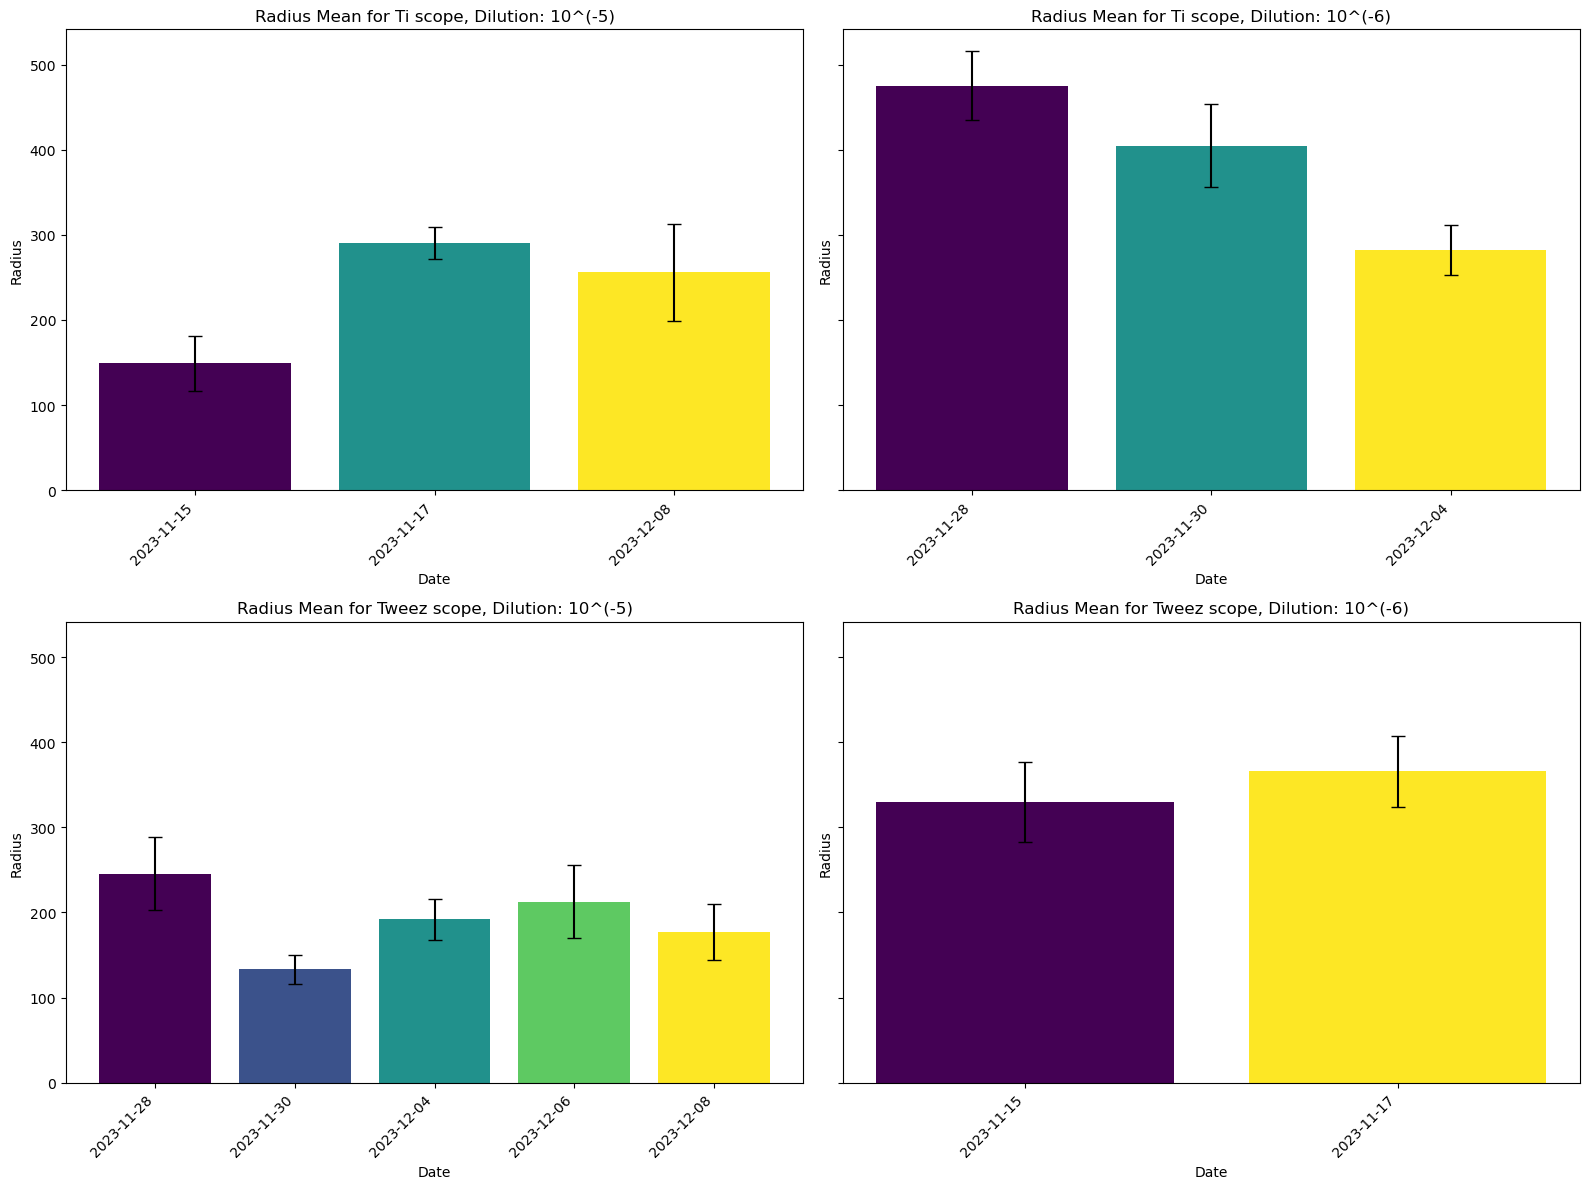

In [22]:
df = df_out.copy()

# Group the data by 'Date', 'Machine', 'Dilution', and calculate mean and standard deviation for 'radius'
plot_data = df.groupby(['Date', 'Machine', 'Dilution']).agg({
    'radius': ['mean', 'std']
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Date', 'Machine', 'Dilution', 'Radius Mean', 'Radius Std']

# Filter data for each machine and dilution type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
machine_dilutions = plot_data['Machine'].unique()
dilutions = plot_data['Dilution'].unique()

# Use a nested loop to create a subplot for each machine-dilution combination
for i, machine in enumerate(machine_dilutions):
    for j, dilution in enumerate(dilutions):
        sub_data = plot_data[(plot_data['Machine'] == machine) & (plot_data['Dilution'] == dilution)]
        if sub_data.empty:
            continue
        radius_colors = plt.cm.viridis(np.linspace(0, 1, len(sub_data)))
        index = 0  # Initialize counter for the color array
        for _, row in sub_data.iterrows():
            axes[i, j].bar(index, row['Radius Mean'], yerr=row['Radius Std'], capsize=5, color=radius_colors[index])
            index += 1  # Increment counter
        
        axes[i, j].set_title(f'Radius Mean for {machine}, Dilution: {dilution}')
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Radius')
        axes[i, j].set_xticks(range(len(sub_data)))
        axes[i, j].set_xticklabels([f"{row['Date'].date()}" for _, row in sub_data.iterrows()], rotation=45, ha="right")

plt.tight_layout()
plt.show()


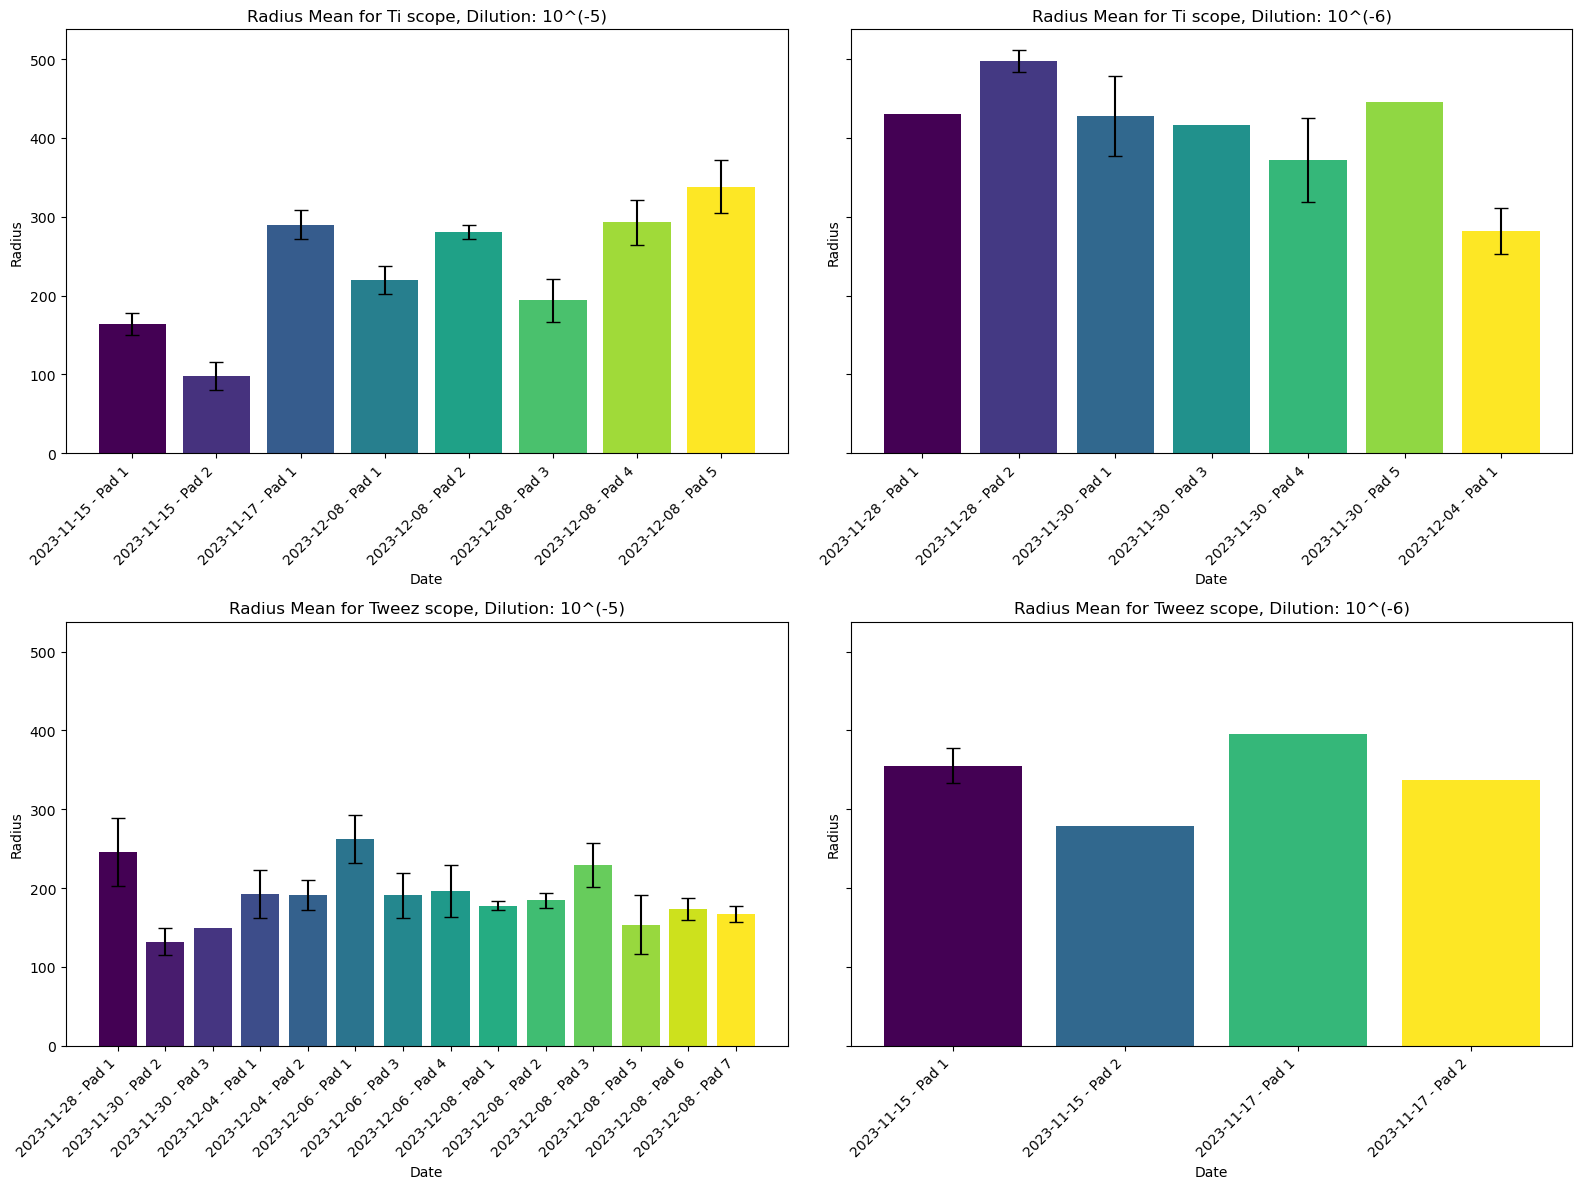

In [24]:

# Group the data by 'Date', 'Machine', 'Dilution', 'Pad' and calculate mean and standard deviation for 'radius'
plot_data = df.groupby(['Date', 'Machine', 'Dilution', 'Pad']).agg({
    'radius': ['mean', 'std']
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Date', 'Machine', 'Dilution', 'Pad', 'Radius Mean', 'Radius Std']

# Filter out dates with only one pad
pad_counts = plot_data.groupby(['Date']).size()
dates_with_multiple_pads = pad_counts[pad_counts > 1].index
filtered_data = plot_data[plot_data['Date'].isin(dates_with_multiple_pads)]

# Filter data for each machine and dilution type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
machine_dilutions = filtered_data['Machine'].unique()
dilutions = filtered_data['Dilution'].unique()

# Use a nested loop to create a subplot for each machine-dilution combination
for i, machine in enumerate(machine_dilutions):
    for j, dilution in enumerate(dilutions):
        sub_data = filtered_data[(filtered_data['Machine'] == machine) & (filtered_data['Dilution'] == dilution)]
        if sub_data.empty:
            continue
        radius_colors = plt.cm.viridis(np.linspace(0, 1, len(sub_data)))
        index = 0  # Initialize counter for the color array
        for _, row in sub_data.iterrows():
            axes[i, j].bar(index, row['Radius Mean'], yerr=row['Radius Std'], capsize=5, color=radius_colors[index])
            index += 1  # Increment counter
        
        axes[i, j].set_title(f'Radius Mean for {machine}, Dilution: {dilution}')
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Radius')
        axes[i, j].set_xticks(range(len(sub_data)))
        axes[i, j].set_xticklabels([f"{row['Date'].date()} - Pad {row['Pad']}" for _, row in sub_data.iterrows()], rotation=45, ha="right")

plt.tight_layout()
plt.show()


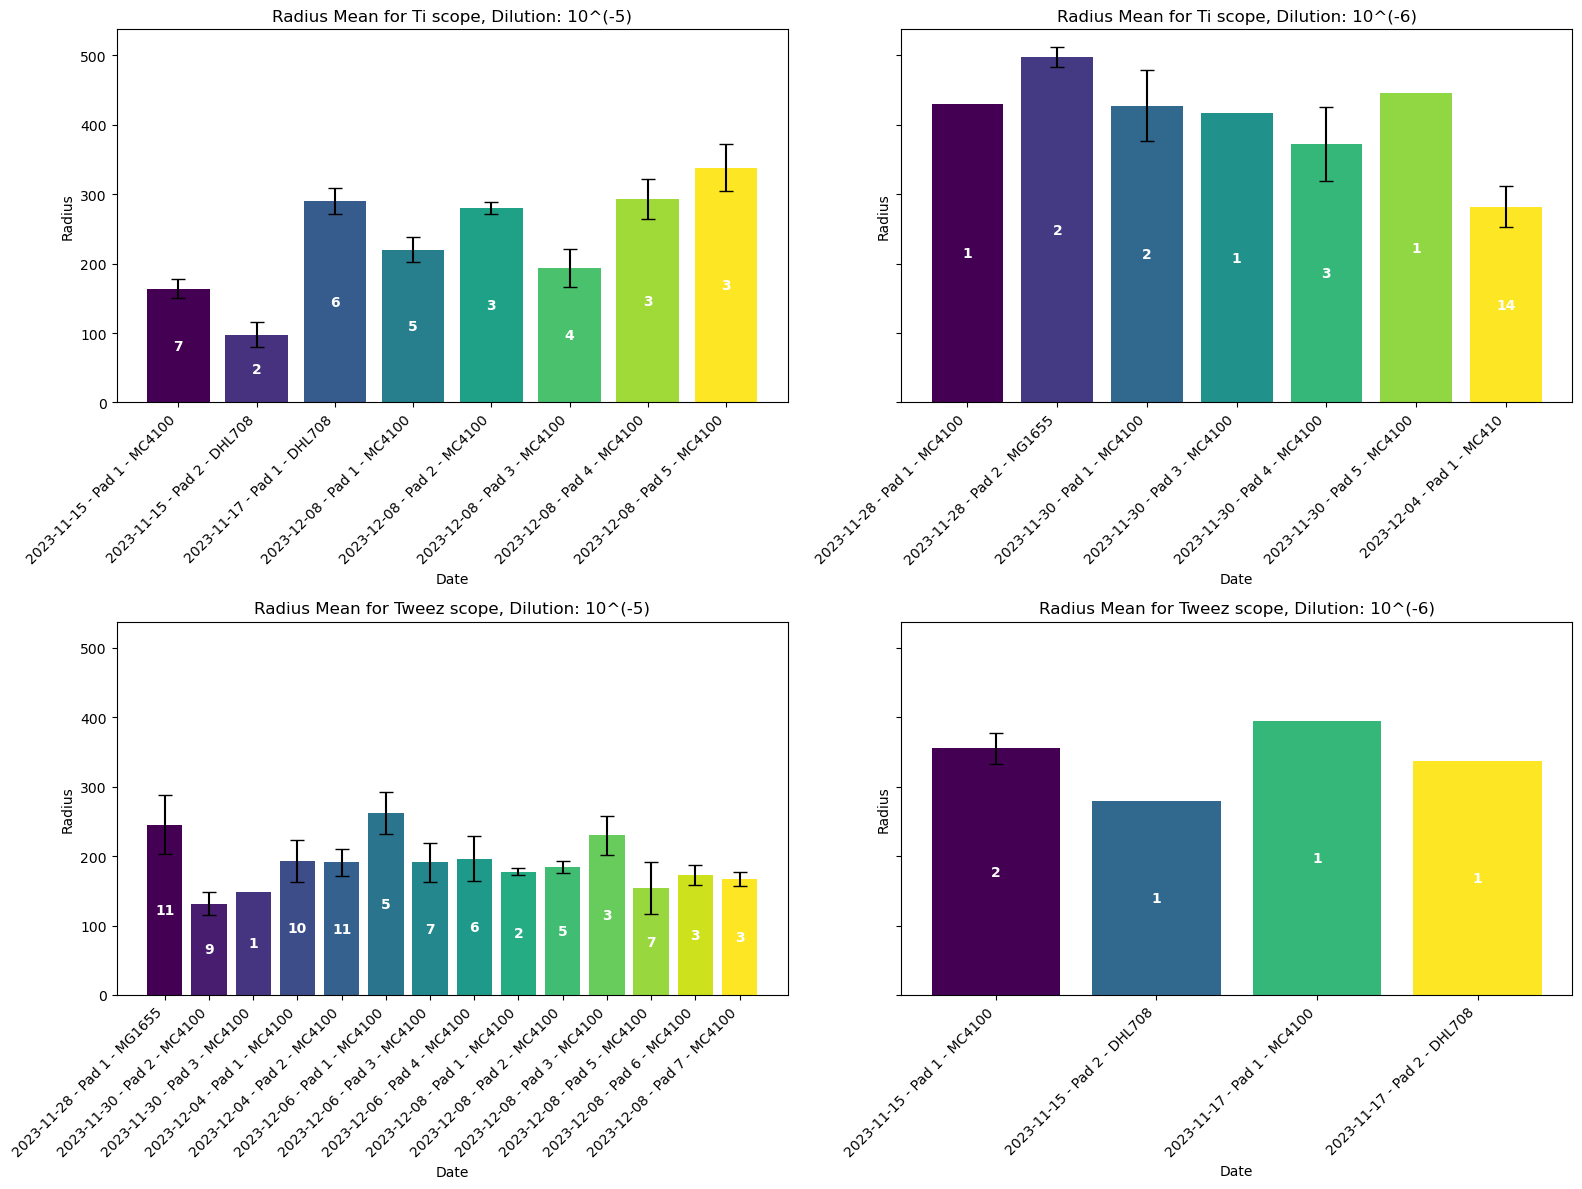

In [27]:


# Group the data by 'Date', 'Machine', 'Dilution', 'Pad', 'Strain' and calculate mean, standard deviation for 'radius' and count colonies
plot_data = df.groupby(['Date', 'Machine', 'Dilution', 'Pad', 'Strain']).agg({
    'radius': ['mean', 'std'],
    'Colonies': 'size'  # This will count the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Date', 'Machine', 'Dilution', 'Pad', 'Strain', 'Radius Mean', 'Radius Std', 'Colonies Count']

# Filter out dates with only one pad
pad_counts = plot_data.groupby(['Date']).size()
dates_with_multiple_pads = pad_counts[pad_counts > 1].index
filtered_data = plot_data[plot_data['Date'].isin(dates_with_multiple_pads)]

# Filter data for each machine and dilution type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
machine_dilutions = filtered_data['Machine'].unique()
dilutions = filtered_data['Dilution'].unique()

# Use a nested loop to create a subplot for each machine-dilution combination
for i, machine in enumerate(machine_dilutions):
    for j, dilution in enumerate(dilutions):
        sub_data = filtered_data[(filtered_data['Machine'] == machine) & (filtered_data['Dilution'] == dilution)]
        if sub_data.empty:
            axes[i, j].set_xticks([])  # No data for this subplot
            continue
        radius_colors = plt.cm.viridis(np.linspace(0, 1, len(sub_data)))
        index = 0  # Initialize counter for the color array
        for _, row in sub_data.iterrows():
            bar = axes[i, j].bar(index, row['Radius Mean'], yerr=row['Radius Std'], capsize=5, color=radius_colors[index])
            # Add text annotation inside the bar
            axes[i, j].text(index, row['Radius Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontweight='bold')
            index += 1  # Increment counter
        
        axes[i, j].set_title(f'Radius Mean for {machine}, Dilution: {dilution}')
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Radius')
        axes[i, j].set_xticks(range(len(sub_data)))
        axes[i, j].set_xticklabels([f"{row['Date'].date()} - Pad {row['Pad']} - {row['Strain']}" for _, row in sub_data.iterrows()], rotation=45, ha="right")

plt.tight_layout()
plt.show()
